In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import time
import os
import pickle
from collections import defaultdict

In [ ]:
#Task: GAN Gernate MNIST:
#dataset
device = "cuda" if torch.cuda.is_available() else "cpu"
input_shape = 28*28
Transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
    #transforms.Normalize((0.5),(0.5))]
)

train_dataset = datasets.MNIST(root='./data', download=True, transform=Transform)#PIL to tensor
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=Transform)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.60MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.91MB/s]


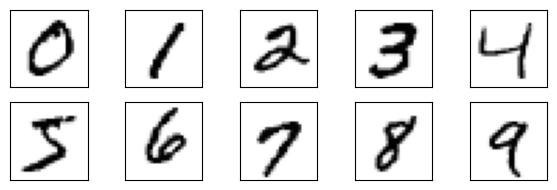

In [ ]:
images, labels = train_dataset.data , train_dataset.targets
#lets visualize:
fig, ax = plt.subplots(nrows =2, ncols=5,sharex = True, sharey = True , figsize = (6,2))
ax = ax.flatten()
for i in range(10):
  img = images[labels == i][0]
  ax[i].imshow(img,cmap =  'Greys')
  #plt.title(f"Label: {i}")

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
train_dataset[0][0].min(), train_dataset[0][0].max()#images from 0-> 255

(tensor(0.), tensor(1.))

In [ ]:
# 4. Split into train and validation sets (80/20 split)
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [ ]:
bSize = 128
# 5. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=bSize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=bSize)
test_loader = DataLoader(test_dataset, batch_size=bSize)
#show the dimensions of each batch:
first_batch = next(iter(train_loader))
first_batch[0].shape

torch.Size([128, 1, 28, 28])

In [ ]:
def draw_images(images,no_images = 25):
  #input: batch of images: [#batch, channels, Height , widht]
  displayed_images = images[:no_images]
  rows = 5
  cols = 5
  fig, ax = plt.subplots(nrows = rows, ncols= cols , figsize = (rows,cols),
                        # Remove padding and spaces
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        # Remove subplot margins
                        subplot_kw={'aspect': 'equal'}) # Ensure square aspect ratio for images)
  ax = ax.flatten()
  for i in range(no_images):
    img = images[i].reshape(28,28)
    ax[i].imshow(img,cmap =  'gray')
    ax[i].axis('off')
  ax[0].set_xticks([])
  ax[0].set_yticks([])
  plt.tight_layout()
  plt.show()


In [ ]:
#GAN ==> Generator , Discriminator
class Generator(nn.Module):
  def __init__(self, z_dim ):
    super().__init__()
    #stack of layer
    self.gen  = nn.Sequential(
       #z (noise) ==> image
        nn.Linear(in_features = z_dim ,out_features = 512),
        nn.ReLU(),
        nn.Linear(in_features= 512, out_features = 28*28), #28 * 28 [height, width]
        nn.Sigmoid(), #to make the output range between  ==> [0, 1]
        #rearrange the image to be #image {#batch , channel , height , width}
        nn.Unflatten(dim = 1, unflattened_size = (1, 28, 28))
    )

  def forward(self, z):
    return self.gen(z)

In [ ]:
class Discrimintor(nn.Module):
  def __init__(self ):
    super().__init__()
    #stack of layer
    self.dec  = nn.Sequential(
        #image {#batch , channel , height , width} (28 , 28) ==> classifier (real / fake)
        nn.Flatten(), #[#batch,  channel * height *width]
        nn.Linear(in_features = 28*28 ,out_features = 256),
        nn.ReLU(),
        nn.Linear(in_features= 256, out_features = 1), #0/1
        nn.Sigmoid() #to make the output range between  ==> [0, 1]

    )

  def forward(self, z):
    return self.dec(z)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')#for saving models and important data

Mounted at /content/drive


In [ ]:
z_dim = 60

In [ ]:

# Set the path
PATH = '/content/drive/MyDrive/NeuroTech/Preparation_Sun_Wednesday/SeventhSession/'#modify it

# Ensure the directory exists
os.makedirs(PATH, exist_ok=True)

# Try to load saved model and parameters
try:
    print("Trying to load saved model and parameters...")

    # Define Generator, Discriminator
    disc = Discrimintor().to(device)
    gen = Generator(z_dim = z_dim).to(device)
    #Loading ....
    disc.load_state_dict(torch.load(PATH + 'discWeights.pth'))
    gen.load_state_dict(torch.load(PATH + 'genWeights.pth'))

    # Epoch and history
    finished_epochs = pickle.load(open(PATH + 'finishedEpochs.pkl', 'rb'))
    history = pickle.load(open(PATH + 'history.pkl', 'rb'))

    print("Generator and Discriminator and parameters loaded successfully.")

except Exception as e:
    print("Initializing new model and parameters...")
    #print("Reason:", e)

    # Define Generator, Discriminator
    disc = Discrimintor().to(device)
    gen = Generator(z_dim = z_dim).to(device)

    # Initialize variables
    finished_epochs = 0
    history = defaultdict(list)
    print("New Generator and Discriminator and parameters initialized.")


Trying to load saved model and parameters...
Initializing new model and parameters...
New Generator and Discriminator and parameters initialized.


In [ ]:
#loss function ,optimizer
loss = torch.nn.BCELoss()
#optimizer:
disc_opt = optim.Adam(disc.parameters(), lr = 1e-4 )
gen_opt = optim.Adam(gen.parameters(),lr = 1e-4)
Tensor = torch.cuda.FloatTensor if device =='cuda' else torch.FloatTensor

In [ ]:
Tensor

torch.cuda.FloatTensor

In [ ]:
#try to use Tensor
T  = Tensor(np.random.randn(2,2))
type(T)
# z = torch.normal(mean  = 0, std  = 1, size  =(64, 100))
# gen(z).shape# image

/tmp/ipython-input-14-428281902.py:2: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  T  = Tensor(np.random.randn(2,2))


torch.Tensor

In [ ]:
#load pretrained model to calculate Classifier score(inception Score) as a metric to assess to the quality of images

PATH_Classifier =  '/content/drive/MyDrive/NeuroTech/Preparation_Sun_Wednesday/FifthSession/'
# load the scripted model
preTrained_model = torch.jit.load(PATH_Classifier+ "traced_model.pt")

In [ ]:
#Classifier score function: we can learn how use it from "MNIST classifier Project"
def IS(probs):
  #calculate marginal probability p(y)
  p_y = torch.mean(probs, axis = 0)#for each class
  #calculate k_l KL divergence for each outcome
  kl_div = torch.sum( probs * torch.log(probs / p_y), axis = 1)#just for showing
  #calculate IS
  inception_score = torch.exp(kl_div.mean())
  return inception_score


def MNIST_Classifier_Score(model , generated_images , n_splits = 10):
  #this function try to mimic Inception score function to assess the generative models like GAN:
  #to measure diversity and quality of generated MNIST daata
  #so we need to leverage from our classifier to assess these architectures.
  #note our classifier accuray reach to 97.8% , so it may be authentic to do this task!
  ################################
  ###### Prediction Step #########
  ################################
  test_loader = DataLoader(generated_images, batch_size=64)
  y_pred = []
  #for GAN architectures, we don't have actual labels:
  with torch.no_grad():
      for features in test_loader:
        features = features.to(device)
        logits, y_hat = model(features)
        y_pred.extend(y_hat)
  ################################
  ###### Calculate IS ############
  ################################
  #print("no of prediction output: ", torch.stack(y_pred).shape)
  #print( "no of Split Batches  : ", int(len(y_pred)/n_splits))
  labels_batches = torch.split(torch.stack(y_pred), int(len(y_pred)/n_splits))#divide labels predictions to chunks based on n-splits
  Is_s = np.array([IS(probs).cpu().numpy() for probs in labels_batches])
  return Is_s.mean() , Is_s.std()



In [ ]:
def train(  generator,
            discriminator,
            gen_optimizer,
            disc_optimizer,
            criterion,
            device,
            dataset_loader,
            epochs_,
            finished_epochs,
            z_dim,
            batch_size,
            PATH
        ):
    #training procedure:
    Tensor = torch.cuda.FloatTensor if device =='cuda' else torch.FloatTensor
    history = defaultdict(list)
    start_time = time.time()
    #for long training peroids:
    #if the training intruppted because the session time is gone or any other problem
    epochs = epochs_ - finished_epochs
    current_epoch = finished_epochs
    print("The training is strating from epoch: ",current_epoch)
    print("**************************************")

    for epoch in range(epochs):
        epoch_start_time = time.time()
        generator_loss_train = 0
        discriminator_loss_train = 0
        for images , _ in dataset_loader:
            batch_len = images.size(0)
            #noise = torch.randn(batch_size, z_dim).to(device)
            z = Tensor(np.random.randn(batch_len, z_dim))
            fake_images = generator(z)
            images = images.to(device)
            ################################
            #####training Discriminator######
            #################################
            predict_real = discriminator(images) #y_hat for real dataset
            predict_fake = discriminator(fake_images.detach())#y_hat for generator images
            #loss for discrimintor
            loss_real = loss(predict_real,Tensor(np.ones(predict_real.shape)))
            loss_fake  = loss(predict_fake, Tensor(np.zeros(predict_fake.shape)))
            loss_disc = loss_real + loss_fake
            disc_optimizer.zero_grad()
            loss_disc.backward()
            disc_optimizer.step()
            discriminator_loss_train += loss_disc.item()
            ################################
            #####training Generator#########
            #################################
            #min log (1 - D( G(z))) , for rapid covergence we try to min -log D(G(Z)
            predict_gen_images = discriminator(fake_images)
            loss_gen = loss(predict_gen_images, Tensor(np.ones(predict_gen_images.shape)))
            gen_optimizer.zero_grad()
            loss_gen.backward()
            gen_optimizer.step()
            generator_loss_train += loss_gen.item()
        current_epoch +=1
        history['genertor_train_loss'].append(generator_loss_train/len(dataset_loader))
        history['discriminator_train_loss'].append(discriminator_loss_train/len(dataset_loader))
        #validation Check:
        n = 5000
        n_images_drawn = 25
        if epoch % 10  == 0:
            with torch.no_grad():
                noise = Tensor(np.random.randn(n, z_dim))
                images_ = generator(noise)

                ######################################################
                ###########Calculating Classifier(inception) Score#####
                #######################################################
                #let's try on validation dataset :10,000:
                #remindar: we need only generated images that classified by pretrained model , then apply probability concepts to calculate IS
                m , s = MNIST_Classifier_Score(model = preTrained_model, generated_images = images_  , n_splits = 5)
                history['mean_IS'].append(m)
                #for efficient print
                if epoch % 100  == 0:
                  draw_images(images_[:n_images_drawn].cpu())
                  print("Classifier Score: ","Av: ", m ,"STD: ", s )

                #Future work: we can use IS for early stopping
            finished_epochs = current_epoch
            #Saving our models:
            torch.save(generator.state_dict(),PATH+'genWeights.pth')
            torch.save(discriminator.state_dict(),PATH+'discWeights.pth')
            pickle.dump(finished_epochs, open(PATH +'finishedEpochs.pkl', 'wb'))
            pickle.dump(history, open(PATH +'history.pkl', 'wb'))
            #Future work
            #we need to save models depend on our Experiments like saving models for each differen epochs number or differnet batch_size , to retrive good models efficiently
        if epoch % 10  == 0:
          print(f'epoch: {epoch} , Generator Loss: {loss_gen.item():0.4f}, Discriminator Loss: {loss_disc.item():0.4f}', end=' ')
          print(f"Time Elapsed: {(time.time() - epoch_start_time)/60 :0.2f} min")
    print(f"Total Time Elapsed:  {(time.time() - start_time)/60 :0.2f} min")
    return history

In [ ]:
bSize = 128

The training is strating from epoch:  0
**************************************


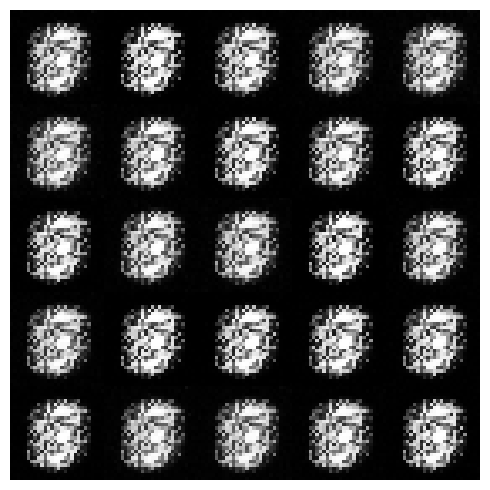

Classifier Score:  Av:  1.0062599 STD:  0.00015099095
epoch: 0 , Generator Loss: 1.5252, Discriminator Loss: 0.9373 Time Elapsed: 0.11 min
epoch: 10 , Generator Loss: 1.6830, Discriminator Loss: 0.7015 Time Elapsed: 0.10 min
epoch: 20 , Generator Loss: 1.6460, Discriminator Loss: 0.6951 Time Elapsed: 0.10 min
epoch: 30 , Generator Loss: 2.6443, Discriminator Loss: 0.1704 Time Elapsed: 0.09 min
epoch: 40 , Generator Loss: 2.5982, Discriminator Loss: 0.2217 Time Elapsed: 0.09 min
epoch: 50 , Generator Loss: 3.0374, Discriminator Loss: 0.3482 Time Elapsed: 0.09 min
epoch: 60 , Generator Loss: 3.2625, Discriminator Loss: 0.2786 Time Elapsed: 0.10 min
epoch: 70 , Generator Loss: 3.6744, Discriminator Loss: 0.4073 Time Elapsed: 0.10 min
epoch: 80 , Generator Loss: 2.9956, Discriminator Loss: 0.3426 Time Elapsed: 0.09 min
epoch: 90 , Generator Loss: 2.8224, Discriminator Loss: 0.3774 Time Elapsed: 0.09 min


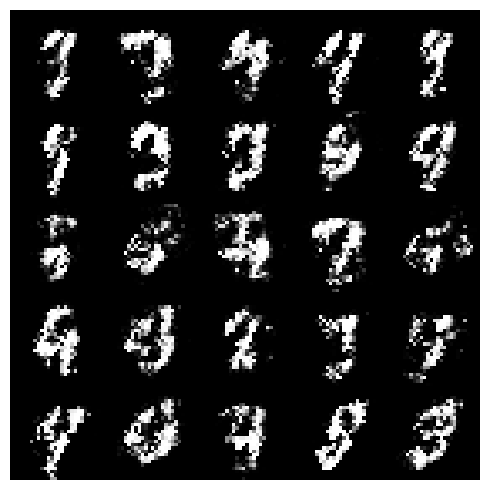

Classifier Score:  Av:  3.168832 STD:  0.014528035
epoch: 100 , Generator Loss: 3.5882, Discriminator Loss: 0.8451 Time Elapsed: 0.10 min
epoch: 110 , Generator Loss: 1.8836, Discriminator Loss: 0.6575 Time Elapsed: 0.10 min
epoch: 120 , Generator Loss: 2.1140, Discriminator Loss: 0.6628 Time Elapsed: 0.09 min
epoch: 130 , Generator Loss: 2.4647, Discriminator Loss: 0.4963 Time Elapsed: 0.09 min
epoch: 140 , Generator Loss: 2.2433, Discriminator Loss: 0.4723 Time Elapsed: 0.09 min
epoch: 150 , Generator Loss: 2.3409, Discriminator Loss: 0.7308 Time Elapsed: 0.09 min
epoch: 160 , Generator Loss: 2.0233, Discriminator Loss: 0.4580 Time Elapsed: 0.10 min
epoch: 170 , Generator Loss: 1.9562, Discriminator Loss: 1.0128 Time Elapsed: 0.09 min
epoch: 180 , Generator Loss: 1.8044, Discriminator Loss: 0.6798 Time Elapsed: 0.09 min
epoch: 190 , Generator Loss: 2.4307, Discriminator Loss: 0.7180 Time Elapsed: 0.09 min


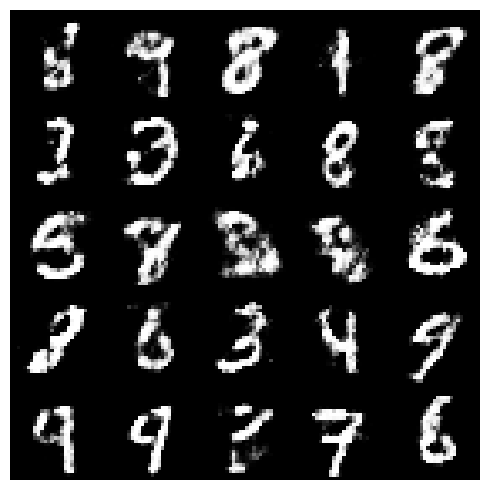

Classifier Score:  Av:  4.445611 STD:  0.058163427
epoch: 200 , Generator Loss: 2.1263, Discriminator Loss: 0.5350 Time Elapsed: 0.10 min
epoch: 210 , Generator Loss: 1.6293, Discriminator Loss: 0.9256 Time Elapsed: 0.10 min
epoch: 220 , Generator Loss: 1.7553, Discriminator Loss: 0.7928 Time Elapsed: 0.09 min
epoch: 230 , Generator Loss: 1.9406, Discriminator Loss: 0.6848 Time Elapsed: 0.09 min
epoch: 240 , Generator Loss: 2.1503, Discriminator Loss: 0.6570 Time Elapsed: 0.09 min
epoch: 250 , Generator Loss: 2.0556, Discriminator Loss: 0.7289 Time Elapsed: 0.10 min
epoch: 260 , Generator Loss: 1.9969, Discriminator Loss: 0.4742 Time Elapsed: 0.10 min
epoch: 270 , Generator Loss: 2.3195, Discriminator Loss: 0.4190 Time Elapsed: 0.09 min
epoch: 280 , Generator Loss: 2.3242, Discriminator Loss: 0.3532 Time Elapsed: 0.09 min
epoch: 290 , Generator Loss: 2.3157, Discriminator Loss: 0.4846 Time Elapsed: 0.10 min


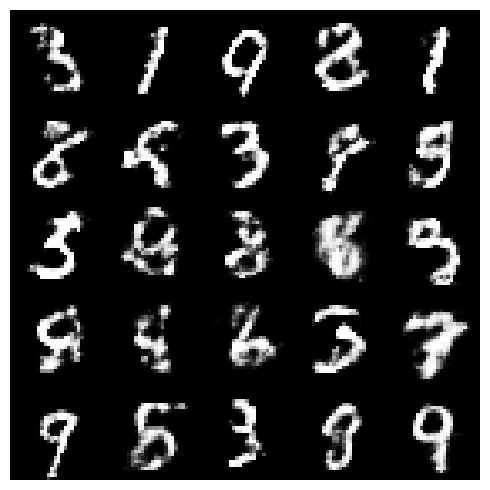

Classifier Score:  Av:  4.2286253 STD:  0.05063362
epoch: 300 , Generator Loss: 2.3118, Discriminator Loss: 1.0083 Time Elapsed: 0.11 min
epoch: 310 , Generator Loss: 2.3875, Discriminator Loss: 0.5479 Time Elapsed: 0.09 min
epoch: 320 , Generator Loss: 1.9432, Discriminator Loss: 0.6325 Time Elapsed: 0.09 min
epoch: 330 , Generator Loss: 2.6224, Discriminator Loss: 0.6358 Time Elapsed: 0.10 min
epoch: 340 , Generator Loss: 1.8641, Discriminator Loss: 0.6108 Time Elapsed: 0.10 min
epoch: 350 , Generator Loss: 2.0347, Discriminator Loss: 0.6725 Time Elapsed: 0.09 min
epoch: 360 , Generator Loss: 2.2789, Discriminator Loss: 0.7330 Time Elapsed: 0.09 min
epoch: 370 , Generator Loss: 2.7222, Discriminator Loss: 0.4382 Time Elapsed: 0.10 min
epoch: 380 , Generator Loss: 1.8624, Discriminator Loss: 0.7667 Time Elapsed: 0.10 min
epoch: 390 , Generator Loss: 2.2333, Discriminator Loss: 0.6046 Time Elapsed: 0.09 min


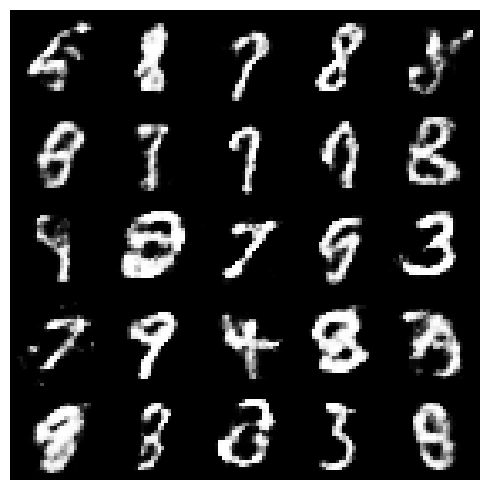

Classifier Score:  Av:  4.1900454 STD:  0.057946466
epoch: 400 , Generator Loss: 1.8880, Discriminator Loss: 0.8998 Time Elapsed: 0.10 min
epoch: 410 , Generator Loss: 2.3870, Discriminator Loss: 0.7344 Time Elapsed: 0.09 min
epoch: 420 , Generator Loss: 2.5330, Discriminator Loss: 0.4562 Time Elapsed: 0.10 min
epoch: 430 , Generator Loss: 1.8592, Discriminator Loss: 0.9422 Time Elapsed: 0.09 min
epoch: 440 , Generator Loss: 2.4232, Discriminator Loss: 0.5143 Time Elapsed: 0.10 min
epoch: 450 , Generator Loss: 1.9393, Discriminator Loss: 0.5464 Time Elapsed: 0.09 min
epoch: 460 , Generator Loss: 2.0883, Discriminator Loss: 0.8273 Time Elapsed: 0.11 min
epoch: 470 , Generator Loss: 2.7301, Discriminator Loss: 0.3237 Time Elapsed: 0.09 min
epoch: 480 , Generator Loss: 2.0159, Discriminator Loss: 0.8744 Time Elapsed: 0.09 min
epoch: 490 , Generator Loss: 2.0437, Discriminator Loss: 0.5920 Time Elapsed: 0.10 min


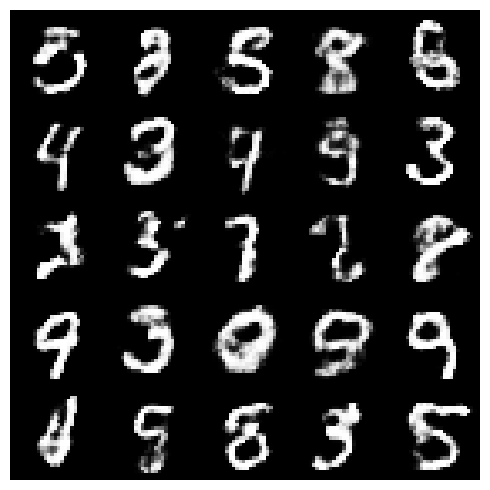

Classifier Score:  Av:  4.1726637 STD:  0.045835283
epoch: 500 , Generator Loss: 2.4237, Discriminator Loss: 0.5513 Time Elapsed: 0.10 min
epoch: 510 , Generator Loss: 3.0419, Discriminator Loss: 0.4555 Time Elapsed: 0.09 min
epoch: 520 , Generator Loss: 2.3583, Discriminator Loss: 0.4777 Time Elapsed: 0.09 min
epoch: 530 , Generator Loss: 2.8186, Discriminator Loss: 0.4414 Time Elapsed: 0.10 min
epoch: 540 , Generator Loss: 2.0508, Discriminator Loss: 0.4880 Time Elapsed: 0.10 min
epoch: 550 , Generator Loss: 2.0408, Discriminator Loss: 0.7301 Time Elapsed: 0.09 min
epoch: 560 , Generator Loss: 2.3765, Discriminator Loss: 0.6910 Time Elapsed: 0.09 min
epoch: 570 , Generator Loss: 2.2610, Discriminator Loss: 0.9325 Time Elapsed: 0.10 min
epoch: 580 , Generator Loss: 2.6092, Discriminator Loss: 0.5648 Time Elapsed: 0.10 min
epoch: 590 , Generator Loss: 1.8118, Discriminator Loss: 1.1301 Time Elapsed: 0.09 min


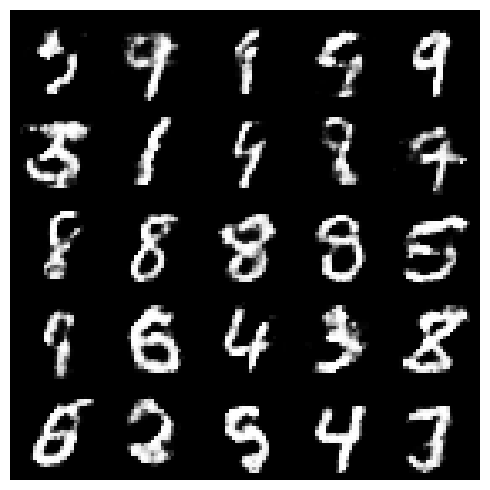

Classifier Score:  Av:  4.119652 STD:  0.093164355
epoch: 600 , Generator Loss: 1.6874, Discriminator Loss: 0.8165 Time Elapsed: 0.10 min
epoch: 610 , Generator Loss: 2.2520, Discriminator Loss: 0.9320 Time Elapsed: 0.10 min
epoch: 620 , Generator Loss: 2.4499, Discriminator Loss: 0.7586 Time Elapsed: 0.10 min
epoch: 630 , Generator Loss: 2.5339, Discriminator Loss: 0.7849 Time Elapsed: 0.09 min
epoch: 640 , Generator Loss: 2.7368, Discriminator Loss: 0.5832 Time Elapsed: 0.09 min
epoch: 650 , Generator Loss: 2.8802, Discriminator Loss: 0.2944 Time Elapsed: 0.10 min
epoch: 660 , Generator Loss: 3.5027, Discriminator Loss: 0.3706 Time Elapsed: 0.10 min
epoch: 670 , Generator Loss: 2.1080, Discriminator Loss: 0.5443 Time Elapsed: 0.09 min
epoch: 680 , Generator Loss: 2.3313, Discriminator Loss: 0.7220 Time Elapsed: 0.09 min
epoch: 690 , Generator Loss: 2.3018, Discriminator Loss: 0.4446 Time Elapsed: 0.10 min


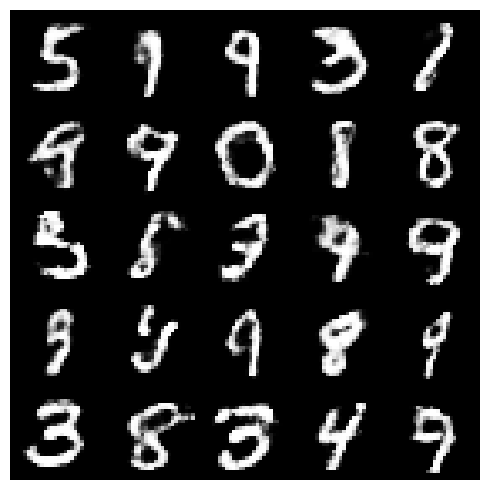

Classifier Score:  Av:  4.044559 STD:  0.045662507
epoch: 700 , Generator Loss: 2.4129, Discriminator Loss: 0.5689 Time Elapsed: 0.10 min
epoch: 710 , Generator Loss: 2.4115, Discriminator Loss: 0.6609 Time Elapsed: 0.09 min
epoch: 720 , Generator Loss: 3.1391, Discriminator Loss: 0.6330 Time Elapsed: 0.09 min
epoch: 730 , Generator Loss: 2.1831, Discriminator Loss: 0.2826 Time Elapsed: 0.10 min
epoch: 740 , Generator Loss: 2.1548, Discriminator Loss: 0.6342 Time Elapsed: 0.10 min
epoch: 750 , Generator Loss: 2.5929, Discriminator Loss: 0.5788 Time Elapsed: 0.09 min
epoch: 760 , Generator Loss: 2.1510, Discriminator Loss: 0.6802 Time Elapsed: 0.09 min
epoch: 770 , Generator Loss: 2.9620, Discriminator Loss: 0.3887 Time Elapsed: 0.10 min
epoch: 780 , Generator Loss: 1.6600, Discriminator Loss: 0.8958 Time Elapsed: 0.10 min
epoch: 790 , Generator Loss: 3.0229, Discriminator Loss: 0.3903 Time Elapsed: 0.09 min


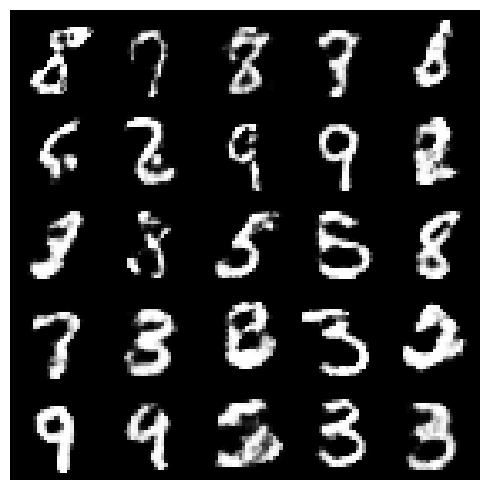

Classifier Score:  Av:  4.049079 STD:  0.026582701
epoch: 800 , Generator Loss: 2.4666, Discriminator Loss: 0.4293 Time Elapsed: 0.10 min
epoch: 810 , Generator Loss: 2.6201, Discriminator Loss: 0.3381 Time Elapsed: 0.10 min
epoch: 820 , Generator Loss: 2.7399, Discriminator Loss: 0.5986 Time Elapsed: 0.10 min
epoch: 830 , Generator Loss: 2.1269, Discriminator Loss: 0.5890 Time Elapsed: 0.09 min
epoch: 840 , Generator Loss: 2.4932, Discriminator Loss: 0.4673 Time Elapsed: 0.09 min
epoch: 850 , Generator Loss: 2.5405, Discriminator Loss: 0.4663 Time Elapsed: 0.10 min
epoch: 860 , Generator Loss: 2.4114, Discriminator Loss: 0.9601 Time Elapsed: 0.10 min
epoch: 870 , Generator Loss: 2.3929, Discriminator Loss: 0.6990 Time Elapsed: 0.09 min
epoch: 880 , Generator Loss: 2.6634, Discriminator Loss: 0.6749 Time Elapsed: 0.09 min
epoch: 890 , Generator Loss: 2.8857, Discriminator Loss: 0.8868 Time Elapsed: 0.10 min


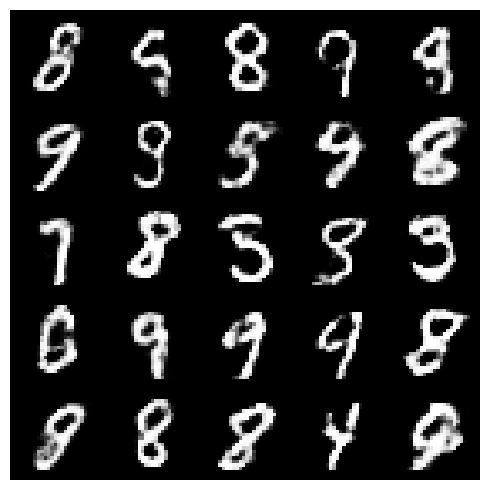

Classifier Score:  Av:  4.005664 STD:  0.07237841
epoch: 900 , Generator Loss: 2.2476, Discriminator Loss: 0.6374 Time Elapsed: 0.10 min
epoch: 910 , Generator Loss: 2.7594, Discriminator Loss: 0.6546 Time Elapsed: 0.09 min
epoch: 920 , Generator Loss: 2.1066, Discriminator Loss: 0.5232 Time Elapsed: 0.09 min
epoch: 930 , Generator Loss: 2.5333, Discriminator Loss: 0.6276 Time Elapsed: 0.10 min
epoch: 940 , Generator Loss: 2.7006, Discriminator Loss: 0.6450 Time Elapsed: 0.10 min
epoch: 950 , Generator Loss: 2.4209, Discriminator Loss: 0.6448 Time Elapsed: 0.09 min
epoch: 960 , Generator Loss: 2.2828, Discriminator Loss: 0.4822 Time Elapsed: 0.09 min
epoch: 970 , Generator Loss: 3.0116, Discriminator Loss: 0.7487 Time Elapsed: 0.10 min
epoch: 980 , Generator Loss: 3.0792, Discriminator Loss: 0.4778 Time Elapsed: 0.10 min
epoch: 990 , Generator Loss: 2.6891, Discriminator Loss: 0.5326 Time Elapsed: 0.09 min
Total Time Elapsed:  92.30 min


In [ ]:
hist = train(
          generator = gen,
            discriminator = disc,
            gen_optimizer = gen_opt,
            disc_optimizer = disc_opt,
            criterion = loss,
            device = device,
            dataset_loader = train_loader,
            epochs_ = 1000,
            finished_epochs =  finished_epochs ,
            z_dim = z_dim,
            batch_size =bSize,
            PATH = PATH
)

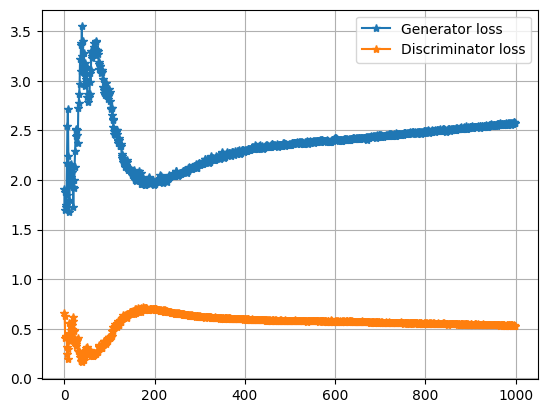

In [ ]:
#draw learing Curves:#losses
plt.plot(hist['genertor_train_loss'], label = 'Generator loss', marker = "*")
plt.plot(hist['discriminator_train_loss'], label = 'Discriminator loss',marker = '*')
plt.legend()
plt.grid(True)
plt.show()#the curves show we can improve more.

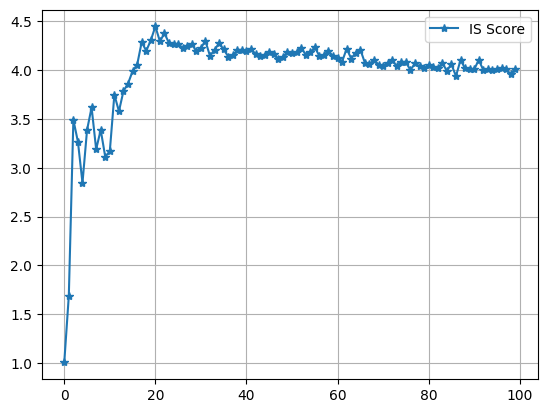

In [ ]:
#draw learing Curves:#losses
plt.plot(hist['mean_IS'], label = 'IS Score', marker = "*")
plt.legend()
plt.grid(True)
plt.show()#the curves show we can improve more.

In [ ]:
#disc(gen(z)).shape# (64, 1)#when enter from Generator

torch.Size([64, 1])

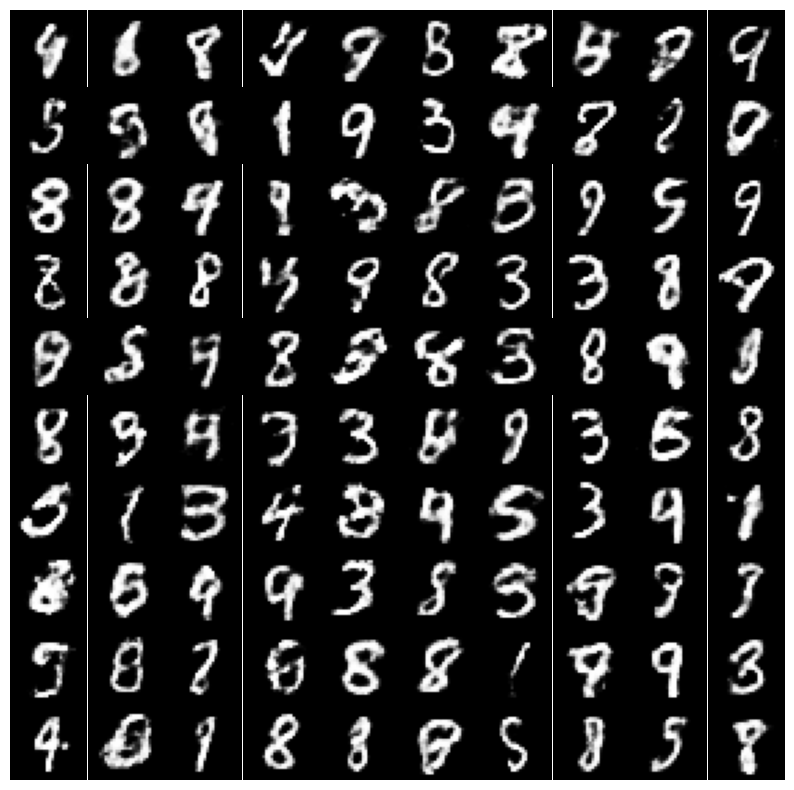

In [ ]:
noise = torch.randn( (100, 60)).to(device)
with torch.no_grad():
  gen_imgs = gen(noise)
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(10, 10),
                      # Remove padding and spaces
                      gridspec_kw={'wspace': 0, 'hspace': 0},
                      # Remove subplot margins
                      subplot_kw={'aspect': 'equal'}) # Ensure square aspect ratio for images

for i, ax in enumerate(axs.flat):
  ax.imshow(gen_imgs[i].cpu().numpy().reshape(28, 28), cmap='gray')
  ax.axis('off')

In [ ]:
#let's try our model(Generator)::
#we generate 16 images using generator (fake)
num_images = 16
with torch.no_grad():
  noise = torch.randn(num_images, z_dim).to(device)
  fake = gen(noise)


16


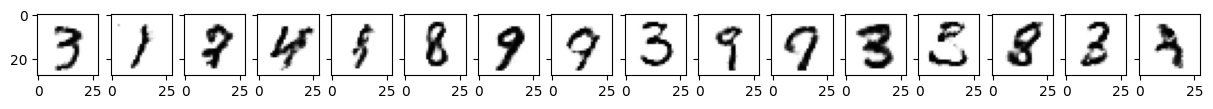

In [ ]:
#visual Evaluation :::For Generator
n_images = 16

generated_images = fake
fig , axes = plt.subplots(nrows = 1, ncols = n_images , figsize = (15,2.5),sharex = True, sharey = True)
print(len(axes))
for i in range(n_images):
    current_im = generated_images[i].detach().cpu()
    axes[i].imshow(current_im.view((28,28)), cmap = "binary")#view is function of pytorch tensor
#one drawback : we don't have any control to produce a certain number.

In [ ]:
#save generator and discriminator whole architecture and parameters:
#######saving Generator############

example_input = torch.randn(bSize, z_dim).to(device)
generator_model = torch.jit.trace(gen, example_input)
# Save the scripted model
generator_model.save(PATH + "generator_model.pt")

###########Saving Dicriminator############
#we can make the image size dynamic
example_input = torch.randn([bSize, 1, 28, 28]).to(device)
discriminator_model = torch.jit.trace(disc, example_input)
# Save the scripted model
discriminator_model.save(PATH + "discriminator_model.pt")